In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
import math
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data\matrix_data.csv").drop("Unnamed: 0", axis=1)
data.drop_duplicates(inplace=True)
data

,Br,C,Cl,F,H,I,N,O,P,S,...,sulfoxide,azido,nitroso,phospate,phospite,isothio,thioamide,nitro2,aromatic,cycle
0,0,20,0,1,20,0,1,2,0,0,...,0,0,0,0,0,0,0,0,3,0
1,0,16,0,0,24,0,5,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,0,25,0,0,22,0,2,2,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,24,0,0,32,0,3,3,0,0,...,0,0,0,0,0,0,0,0,1,3
4,0,20,1,0,18,0,4,2,0,1,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249448,1,14,0,0,23,0,1,3,0,0,...,0,0,0,0,0,0,0,0,1,0
249449,0,10,0,0,8,0,2,3,0,0,...,0,0,0,0,0,0,0,0,2,0
249450,0,23,0,0,26,0,3,2,0,0,...,0,0,0,0,0,0,0,0,2,2
249451,0,22,0,0,29,0,4,3,0,0,...,0,0,0,0,0,0,0,0,1,2


In [3]:
def generate_gaussian_kernel(size, sigma):
    kernel = [0] * size
    sum = 0.0
    center = size // 2
    
    for i in range(size):
        x = i - center
        kernel[i] = math.exp(-(x ** 2) / (2 * sigma ** 2))
        sum += kernel[i]
    
    # Normalize the kernel
    kernel = [x / sum for x in kernel]
    
    return kernel

def gaussian_blur_1d(array, sigma):
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel size is odd
    
    kernel = generate_gaussian_kernel(kernel_size, sigma)
    half_kernel_size = kernel_size // 2
    
    # Apply the Gaussian kernel to the array
    blurred_array = [0] * len(array)
    for i in range(len(array)):
        weighted_sum = 0.0
        kernel_sum = 0.0
        for j in range(kernel_size):
            array_index = i + j - half_kernel_size
            if 0 <= array_index < len(array):
                weighted_sum += array[array_index] * kernel[j]
                kernel_sum += kernel[j]
        blurred_array[i] = weighted_sum / kernel_sum
    
    return blurred_array

In [4]:
X = np.array([gaussian_blur_1d(i, 0.01*len(i)) for i in data.values])
X.shape

(180705, 44)

In [8]:
# Define the ANN model for tokenizing with specific input and output sizes using Sequential
class TokenizerANN(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(TokenizerANN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),  # First hidden layer
            nn.ReLU(),
            nn.Linear(512, 256),       # Third hidden layer
            nn.ReLU(),
            nn.Linear(256, 128),       # Fourth hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),        # Fifth hidden layer
            nn.ReLU(),
            nn.Linear(64, output_size) ,
            nn.Softmax()# Encoder output layer
        )
       
        self.decoder = nn.Sequential(
            nn.Linear(output_size, 64),          # Decoder input layer
            nn.ReLU(),
            nn.Linear(64, 128),        # First hidden layer
            nn.ReLU(),
            nn.Linear(128, 256),       # Second hidden layer
            nn.ReLU(),
            nn.Linear(256, 512),       # Third hidden layer
            nn.ReLU(),
            nn.Linear(512, input_size)   # Decoder output layer
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [12]:
from torchsummary import summary

In [76]:
# Sample data
batch_size = 32
target_size = 4

# Training loop
num_epochs = 50

X_train, X_test, y_train, y_test = train_test_split(X,X , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 

tensor_X_train = torch.from_numpy(X_train).to(device)
tensor_X_test = torch.from_numpy(X_test).to(device)
tensor_y_train = torch.from_numpy(y_train).to(device)
tensor_y_test = torch.from_numpy(y_test).to(device)

# Create DataLoader
dataset = TensorDataset(tensor_X_train, tensor_y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = TokenizerANN(input_size = tensor_X_test.shape[1],
                     output_size=target_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# define history list
class history:
    def __init__(self) -> None:
        self.loss = []
        self.val_loss = []
        self.metric_loss = []
        self.val_metric_loss = []
h = history()

summary(model, (batch_size,  tensor_X_test.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 512]          23,040
              ReLU-2              [-1, 32, 512]               0
            Linear-3              [-1, 32, 256]         131,328
              ReLU-4              [-1, 32, 256]               0
            Linear-5              [-1, 32, 128]          32,896
              ReLU-6              [-1, 32, 128]               0
            Linear-7               [-1, 32, 64]           8,256
              ReLU-8               [-1, 32, 64]               0
            Linear-9                [-1, 32, 4]             260
          Softmax-10                [-1, 32, 4]               0
           Linear-11               [-1, 32, 64]             320
             ReLU-12               [-1, 32, 64]               0
           Linear-13              [-1, 32, 128]           8,320
             ReLU-14              [-1, 

c:\Users\Evint\Documents\Projects\Functional-Group-Analysis\venv\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [77]:
min_loss = 1e5
for epoch in range(num_epochs):
    loss_acc = []
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(torch.tensor(inputs, dtype=torch.float32))
        loss = criterion(outputs, targets.to(torch.float32))
        loss.backward()
        optimizer.step()
        loss_acc.append(loss.item())
    
    epoch_loss = np.mean(loss_acc)
    val_outputs = model(torch.tensor(tensor_X_test, dtype=torch.float32))
    val_loss = criterion(val_outputs, tensor_y_test)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}; val_loss: {val_loss:.4f}", end=" ")
    if min_loss > epoch_loss:
        torch.save(model.state_dict(), "tokenizer_ann_with_decoder.pth")
        min_loss = epoch_loss
        print("saved")

C:\Users\Evint\AppData\Local\Temp\ipykernel_41676\2784129757.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs, dtype=torch.float32))
C:\Users\Evint\AppData\Local\Temp\ipykernel_41676\2784129757.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(tensor_X_test, dtype=torch.float32))


Epoch [1/50] - Loss: 3.4952; val_loss: 0.4327 saved
Epoch [2/50] - Loss: 0.3631; val_loss: 0.3307 saved
Epoch [3/50] - Loss: 0.3146; val_loss: 0.2884 saved
Epoch [4/50] - Loss: 0.2222; val_loss: 0.1800 saved
Epoch [5/50] - Loss: 0.1652; val_loss: 0.1586 saved
Epoch [6/50] - Loss: 0.1553; val_loss: 0.1541 saved
Epoch [7/50] - Loss: 0.1528; val_loss: 0.1527 saved
Epoch [8/50] - Loss: 0.1520; val_loss: 0.1529 saved
Epoch [9/50] - Loss: 0.1517; val_loss: 0.1520 saved
Epoch [10/50] - Loss: 0.1515; val_loss: 0.1518 saved
Epoch [11/50] - Loss: 0.1513; val_loss: 0.1517 saved
Epoch [12/50] - Loss: 0.1512; val_loss: 0.1516 saved
Epoch [13/50] - Loss: 0.1511; val_loss: 0.1514 saved
Epoch [14/50] - Loss: 0.1510; val_loss: 0.1514 saved
Epoch [15/50] - Loss: 0.1509; val_loss: 0.1513 saved
Epoch [16/50] - Loss: 0.1509; val_loss: 0.1515 saved
Epoch [17/50] - Loss: 0.1508; val_loss: 0.1516 saved
Epoch [18/50] - Loss: 0.1508; val_loss: 0.1512 saved
Epoch [19/50] - Loss: 0.1507; val_loss: 0.1512 saved
Ep

In [78]:
from SOM_plus_clustering.modules.som import SOM

In [79]:
data = pd.read_csv("data\matrix_data.csv").drop("Unnamed: 0", axis=1)
data.shape

(249455, 44)

In [86]:
target_size = 3
device = "cuda"
# Create a new instance of the model
loaded_model = TokenizerANN(input_size = data.shape[1],
                     output_size=4).to(device)
# Load the saved state dictionary into the new model instance
loaded_model.load_state_dict(torch.load("tokenizer_ann_with_decoder.pth"))

<All keys matched successfully>

In [87]:
# quantize the model
loaded_model.qconfig = torch.quantization.get_default_qconfig("fbgemm")

model_quantized = torch.quantization.convert(model)
print(model_quantized)

TokenizerANN(
  (encoder): Sequential(
    (0): Linear(in_features=44, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
    (9): Softmax(dim=None)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=44, bias=True)
  )
)


In [88]:
tensor_X = torch.from_numpy(data.values).to(device)

In [89]:
tokenized = loaded_model.encoder(torch.tensor(tensor_X, dtype=torch.float32)).to("cpu").detach().numpy()

C:\Users\Evint\AppData\Local\Temp\ipykernel_41676\2874777784.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized = loaded_model.encoder(torch.tensor(tensor_X, dtype=torch.float32)).to("cpu").detach().numpy()


In [90]:
class deep_som:
      def __init__(self) -> None:
            self.layers = [SOM(m=16, n=8, dim=tokenized.shape[1], 
                  initiate_method="SOM++", 
                  neighbour_rad=0.1, 
                  learning_rate=0.1, 
                  distance_function="euclidean"),
                        SOM(m=8, n=4, dim=tokenized.shape[1], 
                  initiate_method="SOM++", 
                  neighbour_rad=0.1, 
                  learning_rate=0.1, 
                  distance_function="euclidean"),
                        SOM(m=4, n=2, dim=tokenized.shape[1], 
                  initiate_method="SOM++", 
                  neighbour_rad=0.1, 
                  learning_rate=0.1, 
                  distance_function="euclidean"),
                        SOM(m=2, n=2, dim=tokenized.shape[1], 
                  initiate_method="SOM++", 
                  neighbour_rad=0.1, 
                  learning_rate=0.1, 
                  distance_function="euclidean")]
      
      def fit(self, X, epoch=10):
            data = X
            for layer in self.layers:
                  layer.fit(data, epoch=epoch)
                  data = layer.cluster_center_
      
      def predict(self, X):
            return self.layers[-1].predict(X)
      
      @property
      def cluster_center_(self):
            return [layer.cluster_center_ for layer in self.layers]

In [91]:
som_model = deep_som()
som_model.fit(X=tokenized, epoch = 50)
predict = som_model.predict(tokenized)

100%|██████████| 50/50 [00:00<00:00, 7158.98it/s]


In [94]:
data = pd.DataFrame(tokenized)
data["label"] = predict
data

,0,1,2,3,label
0,0.412962,0.276234,0.143924,0.166881,3
1,0.364729,0.231037,0.209978,0.194257,3
2,0.269695,0.190407,0.358082,0.181816,1
3,0.293236,0.208118,0.255848,0.242798,3
4,0.400304,0.157213,0.307570,0.134912,3
...,...,...,...,...,...
249450,0.379784,0.116621,0.247086,0.256509,3
249451,0.400907,0.184781,0.212518,0.201793,3
249452,0.158660,0.246263,0.290735,0.304342,3
249453,0.391832,0.146186,0.276050,0.185932,3


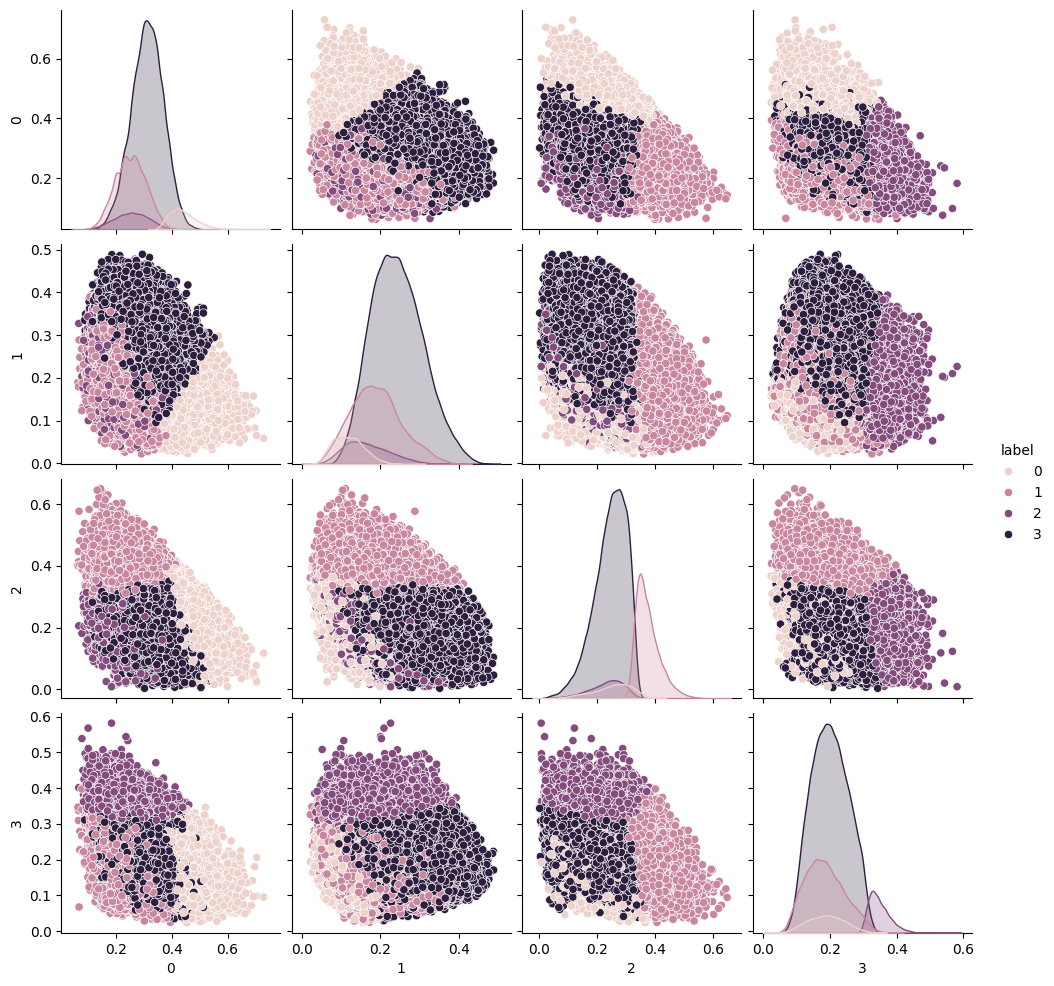

In [95]:
import seaborn as sns
sns.pairplot(data, hue ='label')

In [99]:
data["label"].value_counts()

label
3    164026
1     57700
2     14634
0     13095
Name: count, dtype: int64

In [100]:
raw_data_path = "250k_rndm_zinc_drugs_clean_3.csv"

In [101]:
df = pd.read_csv(raw_data_path)

In [102]:
decoded_cluster_center = loaded_model.decoder(torch.tensor(som_model.cluster_center_[-1], dtype=torch.float32).to("cuda")).to("cpu").detach().numpy()

In [105]:
data = pd.read_csv("data\matrix_data.csv").drop("Unnamed: 0", axis=1)
data.drop_duplicates(inplace=True)
data

,Br,C,Cl,F,H,I,N,O,P,S,...,sulfoxide,azido,nitroso,phospate,phospite,isothio,thioamide,nitro2,aromatic,cycle
0,0,20,0,1,20,0,1,2,0,0,...,0,0,0,0,0,0,0,0,3,0
1,0,16,0,0,24,0,5,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,0,25,0,0,22,0,2,2,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,24,0,0,32,0,3,3,0,0,...,0,0,0,0,0,0,0,0,1,3
4,0,20,1,0,18,0,4,2,0,1,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249448,1,14,0,0,23,0,1,3,0,0,...,0,0,0,0,0,0,0,0,1,0
249449,0,10,0,0,8,0,2,3,0,0,...,0,0,0,0,0,0,0,0,2,0
249450,0,23,0,0,26,0,3,2,0,0,...,0,0,0,0,0,0,0,0,2,2
249451,0,22,0,0,29,0,4,3,0,0,...,0,0,0,0,0,0,0,0,1,2


In [109]:
pd.DataFrame(decoded_cluster_center, columns=data.columns).astype(int).to_csv("data/clustercenter.csv", index=False)
